In [1]:
import pandas as pd
base_multi = pd.read_parquet("patents_multi_cpc.parquet")

In [ ]:
base_multi["year"] = base_multi["publication_date"].astype(str).str[:4].astype(int)
base_multi["year"].describe() # les années vont de 1980 à 2018

count    169330.000000
mean       1996.985643
std           7.242267
min        1980.000000
25%        1990.000000
50%        2000.000000
75%        2003.000000
max        2018.000000
Name: year, dtype: float64

In [5]:
def extract_classe(c):
    return c[:3]

base_multi["liste_classes"] = base_multi["cpc4_list"].apply(
    lambda arr: list({extract_classe(c) for c in arr})
)


In [6]:
# on génère un data set pair-year : on veut compter le nombre d'occurences de chaque pair par an
from itertools import combinations

rows = []

for year, classes in zip(base_multi["year"], base_multi["liste_classes"]):
    for c1, c2 in combinations(sorted(classes), 2):
        rows.append((year, c1, c2))

df_pairs_year = pd.DataFrame(rows, columns=["year", "c1", "c2"])


In [8]:
annual_counts = (
    df_pairs_year
    .groupby(["year", "c1", "c2"])
    .size()
    .reset_index(name="count")
)
annual_counts.head()

,year,c1,c2,count
0,1980,A01,C07,23
1,1980,A01,G06,1
2,1980,A01,H01,1
3,1980,A23,A61,1
4,1980,A23,Y10,1


In [9]:
# Construire une série temporelle par couple (c1, c2)
ts = annual_counts.pivot(index="year", columns=["c1","c2"], values="count").fillna(0)
ts.head()
# on obtient un DataFrame : lignes = années/ colonnes = couples CPC/valeurs = nb de brevets combinant ce couple cette année


c1      A01             A23       A45  A47                 ...  B26  B43  F17  \
c2      C07  G06  H01   A61  Y10  Y10  B04  E05  F25  Y02  ...  H10  C23  G03   
year                                                       ...                  
1980   23.0  1.0  1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  0.0  0.0  0.0   
1981  110.0  0.0  0.0   6.0  4.0  0.0  1.0  2.0  1.0  2.0  ...  0.0  0.0  0.0   
1982  126.0  0.0  0.0   3.0  3.0  1.0  0.0  3.0  1.0  0.0  ...  0.0  0.0  0.0   
1983  118.0  0.0  0.0  11.0  6.0  1.0  0.0  3.0  3.0  1.0  ...  0.0  0.0  0.0   
1984   60.0  0.0  0.0   6.0  6.0  0.0  0.0  2.0  0.0  1.0  ...  0.0  0.0  0.0   

c1    B21  B23  A21  F03  B06  F04  C10  
c2    G04  G04  C01  G03  H05  G07  G04  
year                                     
1980  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1981  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1982  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1983  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1984  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 4975 columns]

In [ ]:
# on veut étudier l'évolution : détection de tendances, ruptures et émergences
# Slope (pente de tendance linéaire) 
# Pour chaque colonne (couple CPC), on calcule la pente de la droite qui approxime la série :
from scipy.stats import linregress

slopes = {}

for col in ts.columns:
    y = ts[col].values
    x = ts.index.values
    slope = linregress(x, y).slope
    slopes[col] = slope



In [11]:
# Définition d’un “seuil de binôme technologique”
# plusieurs méthodes
# 1) Intensité minimale absolue
is_strong = ts >= 20 # un couple est un binome s'il atteint 20 brevets/an

# 2) seuil relatif : si le couple dépasse le 75e quantile de ttes les co-occurences de l'année
threshold = ts.quantile(0.75, axis=1)
# 3) stabilité : couple persistant sur plusieurs années (ici fort sur plus de 3 années de suite)
rolling_strong = is_strong.rolling(window=3, min_periods=3).sum() >= 3

# 4) croissance soutenue : Un couple devient un binôme quand sa pente est > 0 et son intensité dépasse un minimum
binomes = [
    col for col, slope in slopes.items()
    if slope > 0 and ts[col].max() >= 20
]



In [12]:
# exemple avec A61-C07
is_strong[("A61","C07")].plot(title="Force absolue")
(ts[("A61","C07")] > threshold).plot(title="Force relative")
rolling_strong[("A61","C07")].plot(title="Stabilité")
ts[("A61","C07")].plot(title="Évolution brute")


TypeError: no numeric data to plot

In [13]:
# 1) on va définir la période de référence : notre baseline 2000-2010
# on construit un paysage technologique historique, cad les combinaisons habituelles avant l'analyse

baseline = base_multi[(base_multi["year"] >= 2000) & (base_multi["year"] <= 2010)]
# on extrait les couples cpc pour chaque brevet
from itertools import combinations

pairs_baseline = []

for classes in baseline["liste_classes"]:
    for c1, c2 in combinations(sorted(classes), 2):
        pairs_baseline.append((c1, c2))

df_pairs_baseline = pd.DataFrame(pairs_baseline, columns=["c1","c2"])


In [14]:
# on construit la matrice de co-occurence historique
cooc_baseline = (
    df_pairs_baseline
    .groupby(["c1","c2"])
    .size()
    .rename("count")
    .reset_index()
)


In [16]:
# 2) on construit un score d'originalité pour chaque brevet après 2010
after = base_multi[base_multi["year"] > 2010].copy()
baseline_dict = {
    (row.c1, row.c2): row.count
    for row in cooc_baseline.itertuples()
}
def score_originalite(classes):
    score = 0
    for c1, c2 in combinations(sorted(classes), 2):
        freq = baseline_dict.get((c1,c2), 0)
        score += 1 / (1 + freq)
    return score
# si (c1, c2) n'a jamais été vu : il a une oroginalité très forte
# si rare : score élevé
# si très fréquent : score faible

after["originality_score"] = after["liste_classes"].apply(score_originalite)


In [17]:
convergence_index = (
    after.groupby("year")["originality_score"]
    .sum()
    .rename("convergence_index")
)


<Axes: title={'center': 'Indice de convergence technologique'}, xlabel='year'>

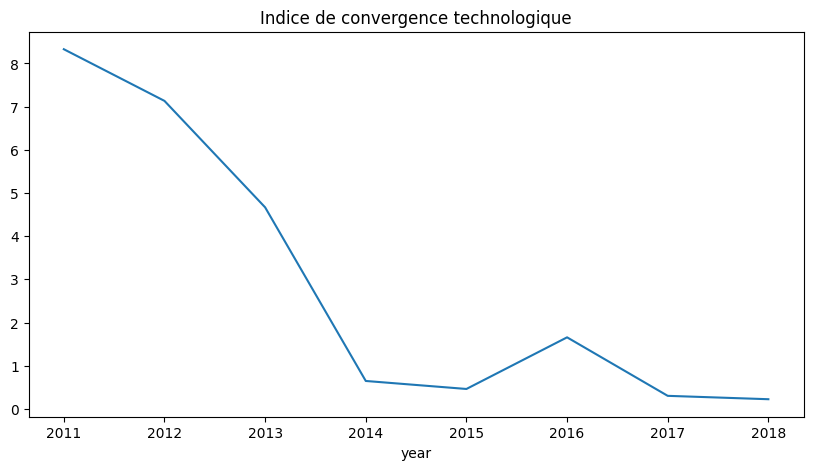

In [18]:
convergence_index.plot(figsize=(10,5), title="Indice de convergence technologique")


In [19]:
# 4) analyse dynamique des co-occurences
# ts = matrice année × couples CPC (déjà construite plus haut)

rolling_ts = ts.rolling(window=5, min_periods=3).sum()


In [27]:
# on construit des graphes annuels des co-occurences par an 
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# 1. Graphe global = union de tous les graphes annuels
G_all = nx.Graph()
for year, G in graphs.items():
    for u, v, data in G.edges(data=True):
        w = data["weight"]
        if G_all.has_edge(u, v):
            G_all[u][v]["weight"] += w
        else:
            G_all.add_edge(u, v, weight=w)

# 2. Layout global (positions fixes pour toutes les années)
pos_global = nx.spring_layout(G_all, seed=0)



In [ ]:
# puis on veut détercter année après année les nouvelles arêtes, les arêtes renforcées, les arêtes affaiblies
changes = {}  # on stockera les infos ici

years = list(ts.index)
for t in range(1, len(years)):
    year_prev = years[t-1]
    year_now  = years[t]
    
    G_prev = graphs[year_prev]
    G_now  = graphs[year_now]
    
    edges_prev = set(G_prev.edges())
    edges_now  = set(G_now.edges())
    
    # nouvelles arêtes 
    new_edges = edges_now - edges_prev
    
    # disparues
    removed_edges = edges_prev - edges_now
    
    # arêtes communes mais à poids différent
    strengthened = []
    weakened = []
    
    for e in edges_now & edges_prev:
        w_prev = G_prev[e[0]][e[1]]["weight"]
        w_now  = G_now[e[0]][e[1]]["weight"]
        
        if w_now > w_prev:
            strengthened.append((e, w_prev, w_now))
        elif w_now < w_prev:
            weakened.append((e, w_prev, w_now))
    
    changes[year_now] = {
        "new_edges": new_edges,
        "removed_edges": removed_edges,
        "strengthened": strengthened,
        "weakened": weakened,
    }


In [22]:
changes[2015]


{'new_edges': {('A23', 'A24'),
  ('A23', 'A61'),
  ('A61', 'A01'),
  ('A61', 'A24'),
  ('B41', 'G07'),
  ('C01', 'H01'),
  ('C01', 'Y02'),
  ('C08', 'G02'),
  ('C09', 'D06'),
  ('C09', 'G02'),
  ('C09', 'Y10'),
  ('C10', 'F23'),
  ('C11', 'C12'),
  ('D06', 'Y10'),
  ('G01', 'G08'),
  ('G01', 'G10'),
  ('G06', 'H02'),
  ('G06', 'H04'),
  ('G06', 'Y04'),
  ('H01', 'H05'),
  ('H05', 'H10'),
  ('Y02', 'B60'),
  ('Y02', 'G06'),
  ('Y02', 'H04'),
  ('Y02', 'H05'),
  ('Y02', 'H10'),
  ('Y02', 'Y04'),
  ('Y04', 'H02')},
 'removed_edges': {('A01', 'C07'),
  ('A01', 'C12'),
  ('A61', 'B82'),
  ('A61', 'C12'),
  ('A61', 'C40'),
  ('A61', 'G01'),
  ('A61', 'H04'),
  ('A61', 'Y10'),
  ('B01', 'C08'),
  ('B01', 'Y02'),
  ('B32', 'B65'),
  ('B65', 'G07'),
  ('C07', 'A61'),
  ('C07', 'B01'),
  ('C07', 'B82'),
  ('C07', 'C08'),
  ('C07', 'C12'),
  ('C07', 'C40'),
  ('C07', 'Y02'),
  ('C12', 'B82'),
  ('C12', 'C11'),
  ('C12', 'C40'),
  ('C12', 'G01'),
  ('C12', 'Y10'),
  ('F05', 'F23'),
  ('G01', 'F02'

In [28]:
def draw_graph_for_year(year, min_weight_year=5):
    G = graphs[year]

    # on ne garde que les arêtes "significatives" cette année
    edges_kept = [
        (u, v) for u, v, d in G.edges(data=True)
        if d["weight"] >= min_weight_year
    ]
    if not edges_kept:
        print(f"Aucune arête avec weight >= {min_weight_year} en {year}")
        return

    fig, ax = plt.subplots(figsize=(8, 6))

    # listes parallèles pour width et couleur
    widths = []
    edge_colors = []

    # infos de changement pour cette année
    new_edges = set()
    strengthened = set()
    if year in changes:
        new_edges = changes[year]["new_edges"]
        strengthened = {e for e, w0, w1 in changes[year]["strengthened"]}

    for e in edges_kept:
        u, v = e
        w = G[u][v]["weight"]

        # largeur en fonction du poids (dans l'année)
        width = 0.5 + 3 * np.log1p(w)
        widths.append(width)

        # couleur selon le type de changement
        if e in new_edges:
            edge_colors.append("green")   # nouvelle arête cette année
        elif e in strengthened:
            edge_colors.append("blue")    # arête qui s'est renforcée
        else:
            edge_colors.append("lightgray")  # arête déjà là, peu de changement

    # dessin : positions globales
    nx.draw(
        G,
        pos_global,
        edgelist=edges_kept,
        with_labels=True,
        node_color="lightyellow",
        edge_color=edge_colors,
        width=widths,
        font_size=8,
        ax=ax
    )

    ax.set_title(f"Évolution technologique : {year}\n"
                 f"(min {min_weight_year} brevets / paire cette année)")
    plt.tight_layout()
    plt.show()



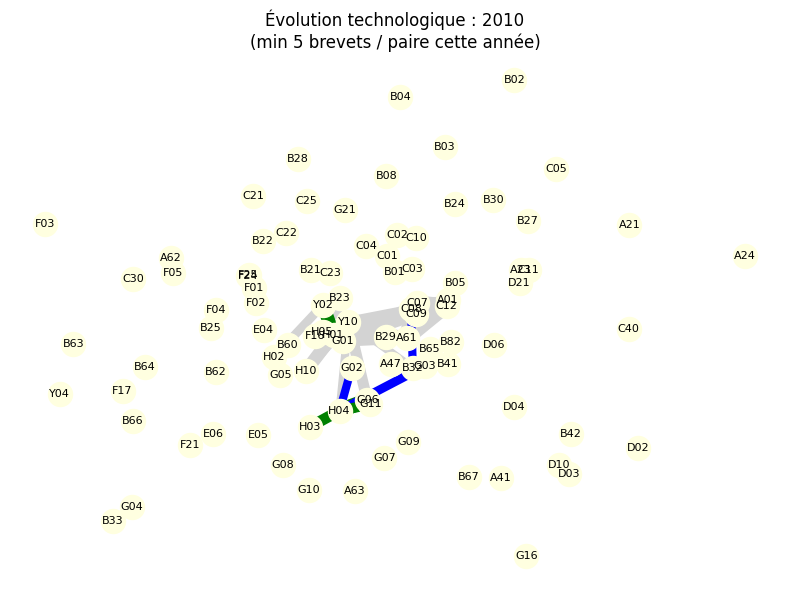

In [ ]:
draw_graph_for_year(2010, min_weight_year=5)
# vert = nouvelle combinaison qui apparait
# bleu : combinaison déjà làmais qui se renforce
# gris clair : combinaison stable, peu intéressante


In [ ]:
# on va maintenant construire des graphes années par année avec les chgts en utilisant en parallèle un dictionnaire des changements
import networkx as nx
import numpy as np
import pandas as pd

# ts : DataFrame index=year, columns=(c1,c2), values=count

# 1. Graphes annuels
graphs = {}

for year in ts.index:
    G = nx.Graph()
    row = ts.loc[year]
    for (c1, c2), w in row.items():
        if w > 0:
            G.add_edge(c1, c2, weight=w)
    graphs[year] = G

# 2. Dictionnaire des changements année par année
changes = {}
years = list(ts.index)

for t in range(1, len(years)):
    year_prev = years[t-1]
    year_now  = years[t]
    
    G_prev = graphs[year_prev]
    G_now  = graphs[year_now]
    
    edges_prev = set(G_prev.edges())
    edges_now  = set(G_now.edges())
    
    # ce qui apparaît entre year_prev et year_now
    new_edges = edges_now - edges_prev
    
    # ce qui disparaît entre year_prev et year_now
    removed_edges = edges_prev - edges_now
    
    strengthened = []
    weakened = []
    
    for e in edges_now & edges_prev:
        w_prev = G_prev[e[0]][e[1]]["weight"]
        w_now  = G_now[e[0]][e[1]]["weight"]
        if w_now > w_prev:
            strengthened.append((e, w_prev, w_now))
        elif w_now < w_prev:
            weakened.append((e, w_prev, w_now))
    
    changes[year_now] = {
        "new_edges": new_edges,
        "removed_edges": removed_edges,
        "strengthened": strengthened,
        "weakened": weakened,
    }


In [32]:
# Graphe global pour fixer une disposition stable
G_all = nx.Graph()
for G in graphs.values():
    for u, v, data in G.edges(data=True):
        w = data["weight"]
        if G_all.has_edge(u, v):
            G_all[u][v]["weight"] += w
        else:
            G_all.add_edge(u, v, weight=w)

pos_global = nx.spring_layout(G_all, seed=0)


In [ ]:
# vert : nouvelle arête (apparue cette année)/ bleu : arête qui se renforce par rapport à l’année précédente/ rouge : arête qui s’affaiblit/ gris clair : arête déjà là, stable

import matplotlib.pyplot as plt

def draw_graph_for_year(year, min_weight_year=3):
    G = graphs[year]
    
    # on ne garde que les arêtes "significatives" cette année
    edges_kept = [
        (u, v) for u, v, d in G.edges(data=True)
        if d["weight"] >= min_weight_year
    ]
    if not edges_kept:
        print(f"Aucune arête avec weight >= {min_weight_year} en {year}")
        return
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    widths = []
    edge_colors = []
    
    new_edges = set()
    strengthened = set()
    weakened = set()
    
    if year in changes:
        new_edges     = changes[year]["new_edges"]
        strengthened  = {e for e, w0, w1 in changes[year]["strengthened"]}
        weakened      = {e for e, w0, w1 in changes[year]["weakened"]}
    
    for e in edges_kept:
        u, v = e
        w = G[u][v]["weight"]
        
        # largeur = log(1+weight)
        width = 0.5 + 3 * np.log1p(w)
        widths.append(width)
        
        if e in new_edges:
            edge_colors.append("green")   # apparaît
        elif e in strengthened:
            edge_colors.append("blue")    # renforcement
        elif e in weakened:
            edge_colors.append("red")     # affaiblissement
        else:
            edge_colors.append("lightgray")   # stable
    
    nx.draw(
        G,
        pos_global,
        edgelist=edges_kept,
        with_labels=True,
        node_color="lightyellow",
        edge_color=edge_colors,
        width=widths,
        font_size=8,
        ax=ax
    )
    
    ax.set_title(
        f"Évolution technologique : {year}\n"
        f"(liens ≥ {min_weight_year} brevets / an)"
    )
    plt.tight_layout()
    plt.show()


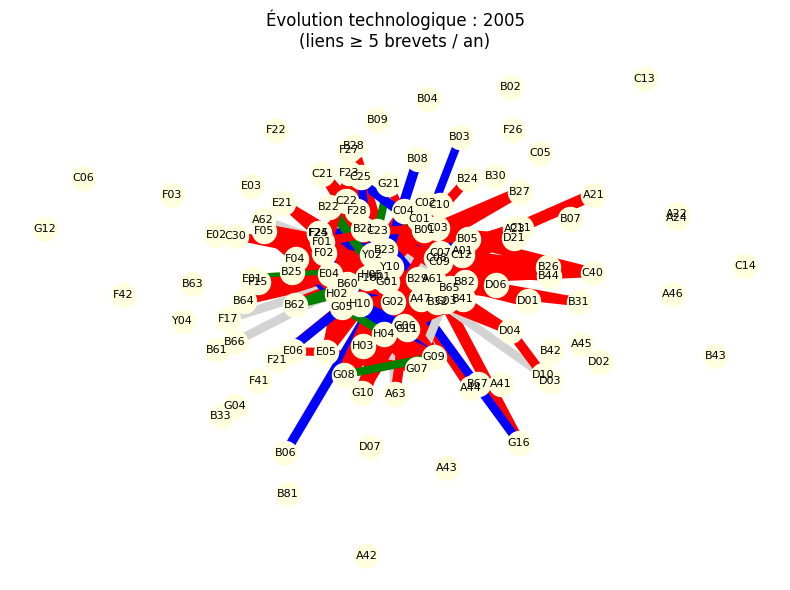

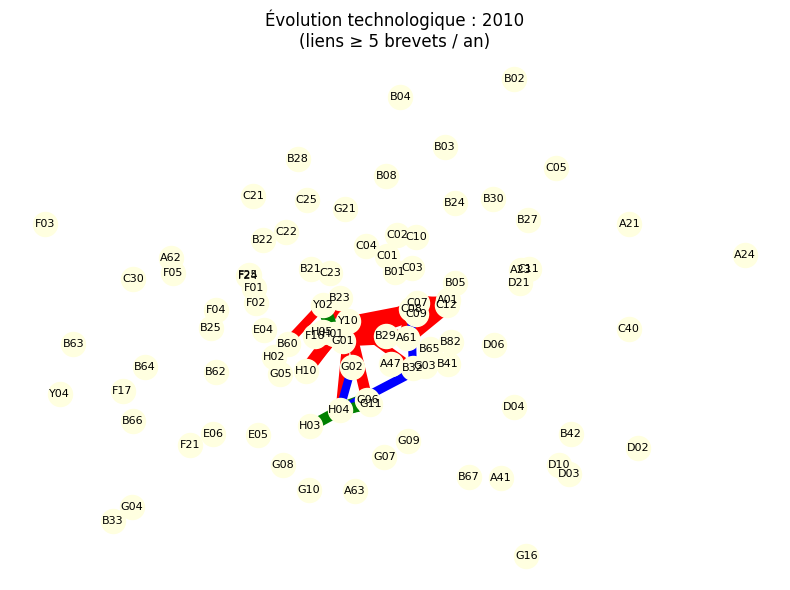

Aucune arête avec weight >= 5 en 2015


In [34]:
draw_graph_for_year(2005, min_weight_year=5)
draw_graph_for_year(2010, min_weight_year=5)
draw_graph_for_year(2015, min_weight_year=5)


In [35]:
# résumé par année
def summary_changes_for_year(year, top_n=10):
    if year not in changes:
        print(f"Pas de comparaison dispo pour {year} (c'est la première année).")
        return
    
    ch = changes[year]
    
    print(f"=== Année {year} ===")
    print(f"Nouvelles arêtes : {len(ch['new_edges'])}")
    print(f"Arêtes disparues : {len(ch['removed_edges'])}")
    print(f"Arêtes renforcées : {len(ch['strengthened'])}")
    print(f"Arêtes affaiblies : {len(ch['weakened'])}")
    print()
    
    # Trier les renforcements / affaiblissements par delta de poids
    strengthened_sorted = sorted(
        ch["strengthened"],
        key=lambda x: x[2] - x[1],  # w_now - w_prev
        reverse=True
    )
    weakened_sorted = sorted(
        ch["weakened"],
        key=lambda x: x[1] - x[2],  # w_prev - w_now
        reverse=True
    )
    
    print(f"Top {top_n} renforcements :")
    for (u, v), w_prev, w_now in strengthened_sorted[:top_n]:
        print(f"  {u}-{v} : {w_prev} → {w_now} (+{w_now - w_prev})")
    
    print()
    print(f"Top {top_n} affaiblissements :")
    for (u, v), w_prev, w_now in weakened_sorted[:top_n]:
        print(f"  {u}-{v} : {w_prev} → {w_now} ({w_now - w_prev})")
    
    print()
    print(f"Quelques nouvelles arêtes :")
    for e in list(ch["new_edges"])[:top_n]:
        print(f"  {e[0]}-{e[1]}")
    
    print()
    print(f"Quelques arêtes disparues :")
    for e in list(ch["removed_edges"])[:top_n]:
        print(f"  {e[0]}-{e[1]}")


=== Année 2010 ===
Nouvelles arêtes : 178
Arêtes disparues : 306
Arêtes renforcées : 15
Arêtes affaiblies : 98

Top 10 renforcements :
  F16-G01 : 1.0 → 5.0 (+4.0)
  G03-H04 : 3.0 → 6.0 (+3.0)
  Y10-C23 : 1.0 → 3.0 (+2.0)
  G01-B82 : 1.0 → 3.0 (+2.0)
  H01-C04 : 1.0 → 3.0 (+2.0)
  G02-H04 : 4.0 → 5.0 (+1.0)
  H01-G03 : 2.0 → 3.0 (+1.0)
  G01-C40 : 1.0 → 2.0 (+1.0)
  C08-B32 : 4.0 → 5.0 (+1.0)
  Y10-B65 : 1.0 → 2.0 (+1.0)

Top 10 affaiblissements :
  C07-A61 : 119.0 → 50.0 (-69.0)
  C07-C12 : 79.0 → 30.0 (-49.0)
  A61-C12 : 68.0 → 29.0 (-39.0)
  A61-Y10 : 32.0 → 9.0 (-23.0)
  Y10-C12 : 26.0 → 3.0 (-23.0)
  C07-G01 : 29.0 → 9.0 (-20.0)
  A61-G01 : 31.0 → 12.0 (-19.0)
  C12-G01 : 21.0 → 6.0 (-15.0)
  C07-Y10 : 16.0 → 2.0 (-14.0)
  Y10-Y02 : 21.0 → 8.0 (-13.0)

Quelques nouvelles arêtes :
  H01-F21
  B01-F02
  G21-B08
  D04-D02
  B23-D06
  G21-C23
  C25-C23
  Y02-B32
  G09-G11
  G06-B01

Quelques arêtes disparues :
  G01-G06
  B05-F28
  B05-B82
  G03-G06
  A61-H02
  A23-B82
  B60-B63
  Y10

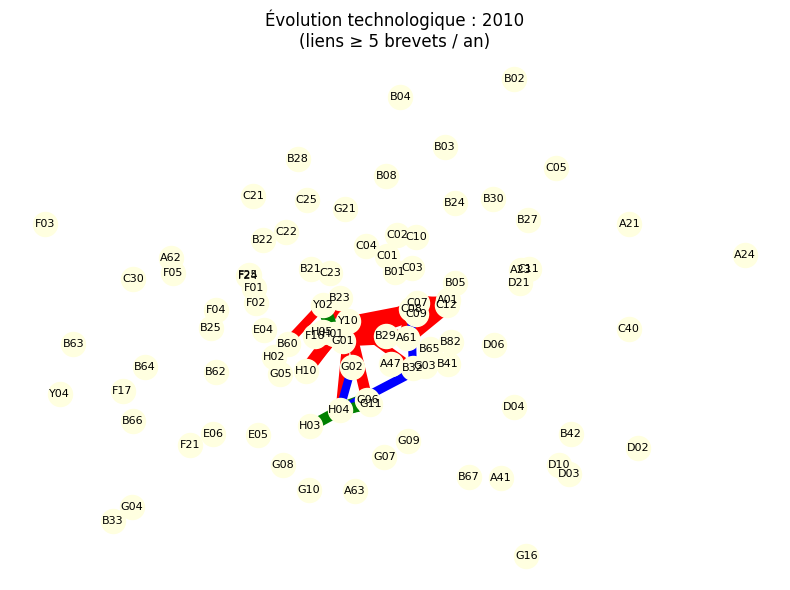

=== Année 2015 ===
Nouvelles arêtes : 28
Arêtes disparues : 55
Arêtes renforcées : 4
Arêtes affaiblies : 1

Top 10 renforcements :
  Y02-H01 : 2.0 → 4.0 (+2.0)
  Y10-G06 : 1.0 → 3.0 (+2.0)
  H01-H10 : 1.0 → 2.0 (+1.0)
  C08-C09 : 1.0 → 2.0 (+1.0)

Top 10 affaiblissements :
  G01-B82 : 2.0 → 1.0 (-1.0)

Quelques nouvelles arêtes :
  Y02-H10
  C09-D06
  C01-Y02
  A23-A61
  G01-G10
  Y02-Y04
  G06-H04
  C08-G02
  C10-F23
  C09-G02

Quelques arêtes disparues :
  C07-C08
  Y10-G02
  G02-H01
  H04-G09
  G06-A63
  H01-C11
  B01-C08
  C12-B82
  C12-C40
  G01-G02
Aucune arête avec weight >= 5 en 2015


In [36]:
summary_changes_for_year(2010)
draw_graph_for_year(2010, min_weight_year=5)

summary_changes_for_year(2015)
draw_graph_for_year(2015, min_weight_year=5)


In [37]:
# en mode chord diagram
import numpy as np

# fréquence totale sur toute la période, pour ordonner les classes
total_counts = ts.sum(axis=0)          # somme sur les années pour chaque (c1,c2)

# récupérer tous les codes CPC présents dans ts
all_codes = set()
for c1, c2 in total_counts.index:
    all_codes.add(c1)
    all_codes.add(c2)

all_codes = list(all_codes)

# (optionnel) si tu veux limiter aux codes les plus utilisés :
# ici on calcule une sorte de "degré pondéré" par code
code_strength = {code: 0 for code in all_codes}
for (c1, c2), val in total_counts.items():
    code_strength[c1] += val
    code_strength[c2] += val

# trier les codes par lettre puis par "force" décroissante
ordered_codes = sorted(
    all_codes,
    key=lambda c: (c[0], -code_strength[c])
)

# positions sur le cercle
n = len(ordered_codes)
angles = np.linspace(0, 2*np.pi, n, endpoint=False)
radius = 1.0

pos_circle = {
    code: (radius * np.cos(theta), radius * np.sin(theta))
    for code, theta in zip(ordered_codes, angles)
}


In [38]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_graph_for_year_circle(year, min_weight_year=3):
    """
    Graphe circulaire pour une année donnée.
    min_weight_year : on ne montre que les arêtes avec au moins ce nb de brevets.
    """
    G = graphs[year]

    # on ne garde que les arêtes significatives cette année
    edges_kept = [
        (u, v) for u, v, d in G.edges(data=True)
        if d["weight"] >= min_weight_year
    ]
    if not edges_kept:
        print(f"Aucune arête avec weight >= {min_weight_year} en {year}")
        return

    fig, ax = plt.subplots(figsize=(8, 8))

    widths = []
    edge_colors = []

    new_edges    = set()
    strengthened = set()
    weakened     = set()

    if year in changes:
        new_edges    = changes[year]["new_edges"]
        strengthened = {e for e, w0, w1 in changes[year]["strengthened"]}
        weakened     = {e for e, w0, w1 in changes[year]["weakened"]}

    for e in edges_kept:
        u, v = e
        w = G[u][v]["weight"]

        # largeur : dépend du nombre de brevets pour ce couple cette année
        widths.append(0.5 + 3 * np.log1p(w))

        # couleur selon le type de changement
        if e in new_edges:
            edge_colors.append("green")   # nouvelle arête (apparition)
        elif e in strengthened:
            edge_colors.append("blue")    # arête renforcée
        elif e in weakened:
            edge_colors.append("red")     # arête affaiblie
        else:
            edge_colors.append("lightgray")  # stable

    # nœuds à afficher : tous ceux de ordered_codes (structure fixe)
    # ou seulement ceux présents dans edges_kept → plus épuré :
    nodes_kept = set()
    for u, v in edges_kept:
        nodes_kept.add(u)
        nodes_kept.add(v)
    nodes_kept = sorted(nodes_kept, key=lambda c: ordered_codes.index(c))

    # dessin : nodes sur le cercle, arêtes au centre
    nx.draw_networkx_nodes(
        G,
        pos_circle,
        nodelist=nodes_kept,
        node_color="lightyellow",
        edgecolors="black",
        node_size=400,
        ax=ax
    )

    nx.draw_networkx_edges(
        G,
        pos_circle,
        edgelist=edges_kept,
        edge_color=edge_colors,
        width=widths,
        alpha=0.8,
        ax=ax
    )

    nx.draw_networkx_labels(
        G,
        pos_circle,
        labels={node: node for node in nodes_kept},
        font_size=8,
        ax=ax
    )

    ax.set_title(
        f"Évolution technologique (vue circulaire) : {year}\n"
        f"liens ≥ {min_weight_year} brevets / an",
        pad=20
    )
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()


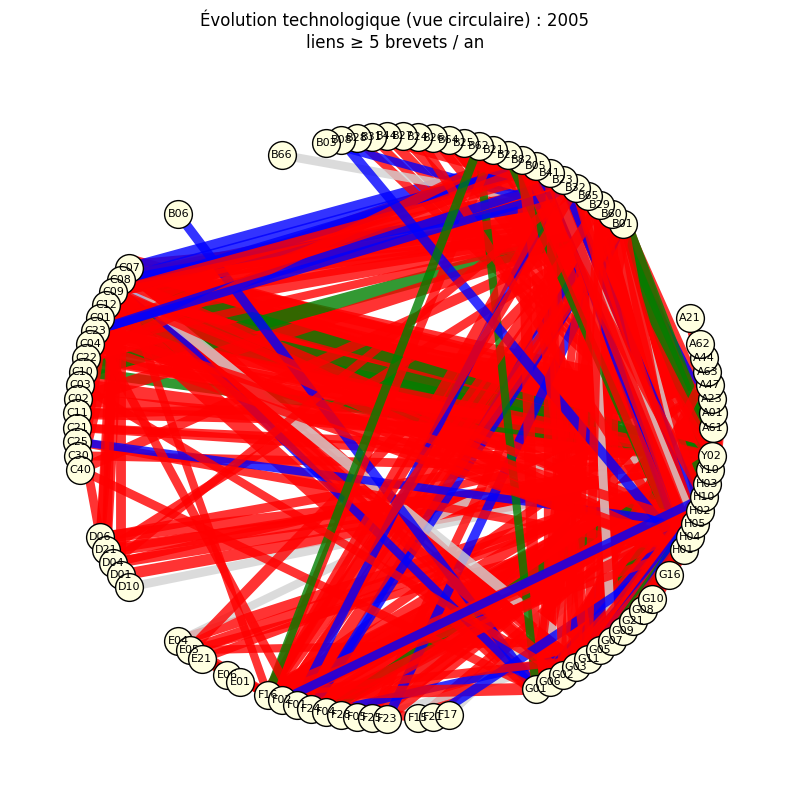

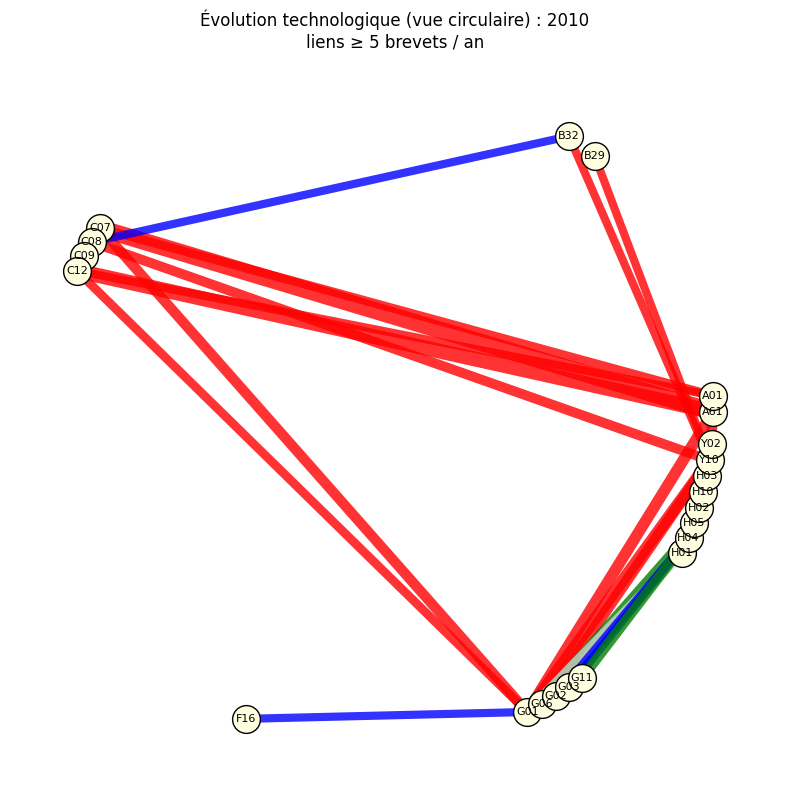

Aucune arête avec weight >= 5 en 2015


In [39]:
draw_graph_for_year_circle(2005, min_weight_year=5)
draw_graph_for_year_circle(2010, min_weight_year=5)
draw_graph_for_year_circle(2015, min_weight_year=5)
